In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print('cuda' if torch.cuda.is_available else 'cpu')

cuda


## Part A: Linear Classification Model

#### Download dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


100%|██████████| 9.91M/9.91M [01:30<00:00, 110kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 143kB/s]
100%|██████████| 1.65M/1.65M [00:07<00:00, 227kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.23MB/s]


In [28]:
# Normalize the dataset
x = train_dataset.data/255
print(x.shape)
# Flatten the dataset (from 60000x28x28 to 60000x784)
x_flattened = x.view(60000, -1)
print(x_flattened.shape)
# Add bias
bias_col = torch.ones((x_flattened.shape[0], 1))
x_flattened = torch.cat((x_flattened, bias_col), dim = 1)
print(x_flattened.shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 784])
torch.Size([60000, 785])


In [14]:
y = train_dataset.targets
y.shape

torch.Size([60000])

In [29]:
y0_1 = y[y<2]

In [30]:
x0_1 = x_flattened[y0_1]
print(f"x0_1 shape: {x0_1.shape}")

x0_1 shape: torch.Size([12665, 785])


In [ ]:
x0_1_train_test, x0_1_test, y0_1_train_test, y0_1_test = train_test_split(x0_1, y0_1, test_size=0.2, random_state=42, stratify=y0_1)
x0_1_train, x0_1_val, y0_1_train, y0_1_val = train_test_split(x0_1_train_test, y0_1_train_test, test_size=0.25, random_state=42, stratify=y0_1_train_test) 
x0_1_train.shape, x0_1_val.shape, x0_1_test.shape, y0_1_train.shape, y0_1_val.shape, y0_1_test.shape

(torch.Size([7599, 785]),
 torch.Size([2533, 785]),
 torch.Size([2533, 785]),
 torch.Size([7599]),
 torch.Size([2533]),
 torch.Size([2533]))

In [91]:
class BinaryLogisticRegression:
    def __init__(self, x_train, y_train, x_val, y_val):
        self.x_train = x_train
        self.y_train = y_train.unsqueeze(1)
        self.x_val = x_val
        self.y_val = y_val.unsqueeze(1)
        self.N = x_train.shape[0]
        self.D = x_train.shape[1]
        self.weights = torch.randn(self.D, 1) * torch.sqrt(torch.tensor(2.0/self.D))  # He initialization
        self.train_history = None

    def _sigmoid(self, x):
        return 1/(1+torch.exp(-x))

    def _forward(self, x):
        z = torch.matmul(x, self.weights)
        y = self._sigmoid(z)
        return y
    
    def _compute_loss(self, y, y_pred):
        eps = 1e-9
        loss = -torch.mean(y*torch.log(y_pred+eps) + (1-y)*torch.log(1-y_pred+eps))
        return loss
    
    def _compute_acc(self, y, y_pred):
        return torch.mean((y == y_pred).float())
    
    def _predict(self):
        predictions = self._forward(self.x_val)
        val_loss = self._compute_loss(self.y_val, predictions)
        labels = (predictions >= 0.5).float()
        val_acc = self._compute_acc(self.y_val, labels)
        return val_loss, val_acc
    
    def _visualize_training_history(self, epochs):
        ep = list(range(1, epochs+1))
        figure, axis = plt.subplots(2, 1, figsize=(10, 8))

        axis[0].plot(ep, self.train_history['train_losses'], color='blue', label='Train Loss')
        axis[0].plot(ep, self.train_history['val_losses'], color='orange', label='Val Loss')
        axis[0].set_title('Loss vs Epochs')
        axis[0].set_xlabel('Epochs')
        axis[0].set_ylabel('Loss')
        axis[0].legend()

        axis[1].plot(ep, self.train_history['train_acc'], color='blue', label='Train Acc')
        axis[1].plot(ep, self.train_history['val_acc'], color='orange', label='Val Acc')
        axis[1].set_title('Accuracy vs Epochs')
        axis[1].set_xlabel('Epochs')
        axis[1].set_ylabel('Accuracy')
        axis[1].legend()

        plt.tight_layout()
        plt.show()
        
    def train(self, lr=0.01, epochs=256):
        self.train_history = {"train_losses":[], "val_losses":[], "train_acc": [], "val_acc": []}
        for epoch in range(epochs):
            y_pred = self._forward(self.x_train)
            train_loss = self._compute_loss(self.y_train, y_pred)
            labels = (y_pred >= 0.5).float()
            train_acc = self._compute_acc(self.y_train, labels)
            self.train_history['train_losses'].append(train_loss.item())
            self.train_history['train_acc'].append(train_acc.item())
            
            dw = torch.matmul(self.x_train.T, (y_pred - self.y_train)) / self.N
            self.weights -= lr * dw
            
            val_loss, val_acc = self._predict()
            self.train_history['val_losses'].append(val_loss.item())
            self.train_history['val_acc'].append(val_acc.item())
            
            if (epoch + 1) % 16 == 0 or epoch < 16:
                print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, train acc = {train_acc:.4f}, val loss = {val_loss:.4f}, val acc = {val_acc:.4f}")
        
        self._visualize_training_history(epochs)
    
    def test(self, x_test, y_test):
        predictions = self._forward(x_test)
        labels = (predictions >= 0.5)
        test_acc = self._compute_acc(y_test.unsqueeze(1).float(), labels)
        print(f"Test accuracy = {test_acc:.4f}")
        cf_matrix = confusion_matrix(y_test.numpy(), labels.squeeze().numpy())
        sns.heatmap(cf_matrix, annot=True, fmt='d')
        plt.show()

Epoch 1: train loss = 0.6781, train acc = 0.5324, val loss = 0.6163, val acc = 0.5322
Epoch 2: train loss = 0.6161, train acc = 0.5324, val loss = 0.5636, val acc = 0.5322
Epoch 3: train loss = 0.5634, train acc = 0.5324, val loss = 0.5187, val acc = 0.5322
Epoch 4: train loss = 0.5185, train acc = 0.5324, val loss = 0.4800, val acc = 1.0000
Epoch 5: train loss = 0.4799, train acc = 1.0000, val loss = 0.4465, val acc = 1.0000
Epoch 6: train loss = 0.4464, train acc = 1.0000, val loss = 0.4172, val acc = 1.0000
Epoch 7: train loss = 0.4171, train acc = 1.0000, val loss = 0.3912, val acc = 1.0000
Epoch 8: train loss = 0.3912, train acc = 1.0000, val loss = 0.3681, val acc = 1.0000
Epoch 9: train loss = 0.3681, train acc = 1.0000, val loss = 0.3474, val acc = 1.0000
Epoch 10: train loss = 0.3473, train acc = 1.0000, val loss = 0.3287, val acc = 1.0000
Epoch 11: train loss = 0.3286, train acc = 1.0000, val loss = 0.3117, val acc = 1.0000
Epoch 12: train loss = 0.3117, train acc = 1.0000, v

Epoch 32: train loss = 0.1467, train acc = 1.0000, val loss = 0.1427, val acc = 1.0000
Epoch 48: train loss = 0.1006, train acc = 1.0000, val loss = 0.0986, val acc = 1.0000
Epoch 64: train loss = 0.0760, train acc = 1.0000, val loss = 0.0748, val acc = 1.0000
Epoch 80: train loss = 0.0608, train acc = 1.0000, val loss = 0.0601, val acc = 1.0000
Epoch 96: train loss = 0.0506, train acc = 1.0000, val loss = 0.0501, val acc = 1.0000
Epoch 112: train loss = 0.0433, train acc = 1.0000, val loss = 0.0429, val acc = 1.0000
Epoch 128: train loss = 0.0378, train acc = 1.0000, val loss = 0.0375, val acc = 1.0000
Epoch 144: train loss = 0.0335, train acc = 1.0000, val loss = 0.0333, val acc = 1.0000
Epoch 160: train loss = 0.0301, train acc = 1.0000, val loss = 0.0299, val acc = 1.0000
Epoch 176: train loss = 0.0273, train acc = 1.0000, val loss = 0.0272, val acc = 1.0000
Epoch 192: train loss = 0.0250, train acc = 1.0000, val loss = 0.0249, val acc = 1.0000
Epoch 208: train loss = 0.0230, train

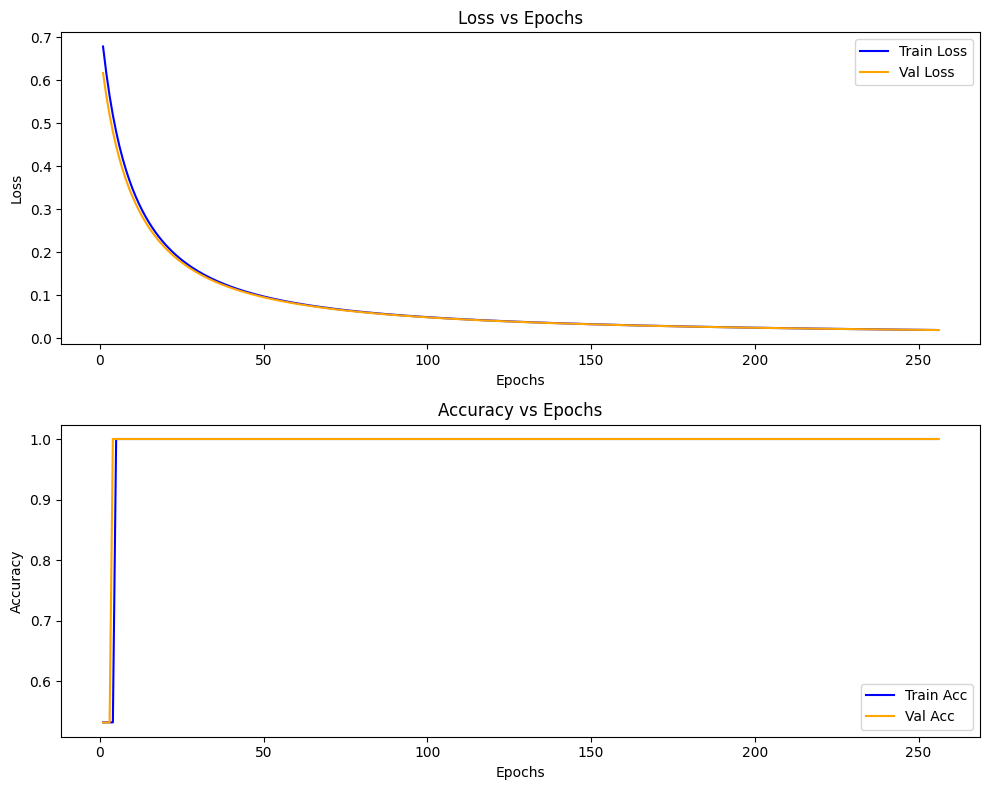

In [92]:
blr = BinaryLogisticRegression(x0_1_train, y0_1_train, x0_1_val, y0_1_val)
blr.train()

Test accuracy = 1.0000


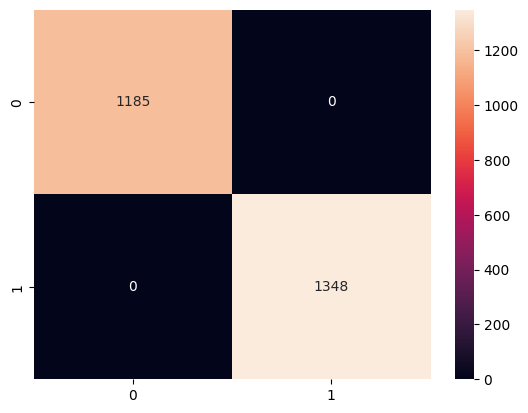

In [93]:
blr.test(x0_1_test, y0_1_test)

In [69]:
x_train_test, x_test, y_train_test, y_test = train_test_split(x_flattened, y, test_size=0.2, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train_test, y_train_test, test_size=0.25, random_state=42, stratify=y_train_test) 
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([36000, 785]),
 torch.Size([12000, 785]),
 torch.Size([12000, 785]),
 torch.Size([36000]),
 torch.Size([12000]),
 torch.Size([12000]))

In [110]:
class SoftmaxRegression:
    def __init__(self, x_train, y_train, x_val, y_val):
        self.x_train = x_train
        self.y_train = F.one_hot(y_train, 10)
        self.x_val = x_val
        self.y_val = F.one_hot(y_val, 10)
        self.N = x_train.shape[0]
        self.D = x_train.shape[1]
        self.weights = torch.randn(self.D, 10) * torch.sqrt(torch.tensor(2.0/self.D))  # He initialization
        self.train_history = None

    
    def _softmax(self, x):
        max_x = torch.max(x, dim=1, keepdim= True)[0] # Prevent overflow
        s = torch.exp(x-max_x)
        return s / torch.sum(s, dim=1, keepdim = True)

    def _forward(self, x):
        z = torch.matmul(x, self.weights)
        y = self._softmax(z)
        return y
    
    def _compute_loss(self, y, y_pred):
        eps = 1e-9
        loss = -torch.mean(torch.sum(y*torch.log(y_pred+eps), dim=1))
        return loss
    
    def _compute_acc(self, y, y_pred):
        y_labels = torch.argmax(y, dim=1)
        y_pred_labels = torch.argmax(y_pred, dim=1)
        return torch.mean((y_labels == y_pred_labels).float())
    
    def _predict(self):
        predictions = self._forward(self.x_val)
        val_loss = self._compute_loss(self.y_val, predictions)
        val_acc = self._compute_acc(self.y_val, predictions)
        return val_loss, val_acc
    
    def _visualize_training_history(self, epochs):
        ep = list(range(1, epochs+1))
        figure, axis = plt.subplots(2, 1, figsize=(10, 8))

        axis[0].plot(ep, self.train_history['train_losses'], color='blue', label='Train Loss')
        axis[0].plot(ep, self.train_history['val_losses'], color='orange', label='Val Loss')
        axis[0].set_title('Loss vs Epochs')
        axis[0].set_xlabel('Epochs')
        axis[0].set_ylabel('Loss')
        axis[0].legend()

        axis[1].plot(ep, self.train_history['train_acc'], color='blue', label='Train Acc')
        axis[1].plot(ep, self.train_history['val_acc'], color='orange', label='Val Acc')
        axis[1].set_title('Accuracy vs Epochs')
        axis[1].set_xlabel('Epochs')
        axis[1].set_ylabel('Accuracy')
        axis[1].legend()

        plt.tight_layout()
        plt.show()
        
    def train(self, lr=0.01, epochs=1024):
        self.train_history = {"train_losses":[], "val_losses":[], "train_acc": [], "val_acc": []}
        for epoch in range(epochs):
            y_pred = self._forward(self.x_train)
            train_loss = self._compute_loss(self.y_train, y_pred)
            train_acc = self._compute_acc(self.y_train, y_pred)
            self.train_history['train_losses'].append(train_loss.item())
            self.train_history['train_acc'].append(train_acc.item())
            
            dw = torch.matmul(self.x_train.T, (y_pred - self.y_train)) / self.N
            self.weights -= lr * dw
            
            val_loss, val_acc = self._predict()
            self.train_history['val_losses'].append(val_loss.item())
            self.train_history['val_acc'].append(val_acc.item())
            
            if (epoch + 1) % 32 == 0:
                print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, train acc = {train_acc:.4f}, val loss = {val_loss:.4f}, val acc = {val_acc:.4f}")
        
        self._visualize_training_history(epochs)
    
    def test(self, x_test, y_test):
        y_test_one_hot = F.one_hot(y_test, 10)
        predictions = self._forward(x_test)
        test_acc = self._compute_acc(y_test_one_hot, predictions)
        print(f"Test accuracy = {test_acc:.4f}")
        labels = torch.argmax(predictions, dim=1)
        cf_matrix = confusion_matrix(y_test.numpy(), labels.numpy())
        sns.heatmap(cf_matrix, annot=True, fmt='d')
        plt.show()



Epoch 32: train loss = 2.0157, train acc = 0.3777, val loss = 2.0104, val acc = 0.3831
Epoch 64: train loss = 1.7736, train acc = 0.5623, val loss = 1.7711, val acc = 0.5544
Epoch 96: train loss = 1.5856, train acc = 0.6564, val loss = 1.5853, val acc = 0.6505
Epoch 128: train loss = 1.4374, train acc = 0.7054, val loss = 1.4388, val acc = 0.7028
Epoch 160: train loss = 1.3193, train acc = 0.7365, val loss = 1.3219, val acc = 0.7358
Epoch 192: train loss = 1.2237, train acc = 0.7582, val loss = 1.2275, val acc = 0.7558
Epoch 224: train loss = 1.1453, train acc = 0.7729, val loss = 1.1500, val acc = 0.7703
Epoch 256: train loss = 1.0801, train acc = 0.7847, val loss = 1.0855, val acc = 0.7806
Epoch 288: train loss = 1.0251, train acc = 0.7933, val loss = 1.0311, val acc = 0.7910
Epoch 320: train loss = 0.9780, train acc = 0.8019, val loss = 0.9847, val acc = 0.7987
Epoch 352: train loss = 0.9374, train acc = 0.8084, val loss = 0.9446, val acc = 0.8052
Epoch 384: train loss = 0.9020, tra

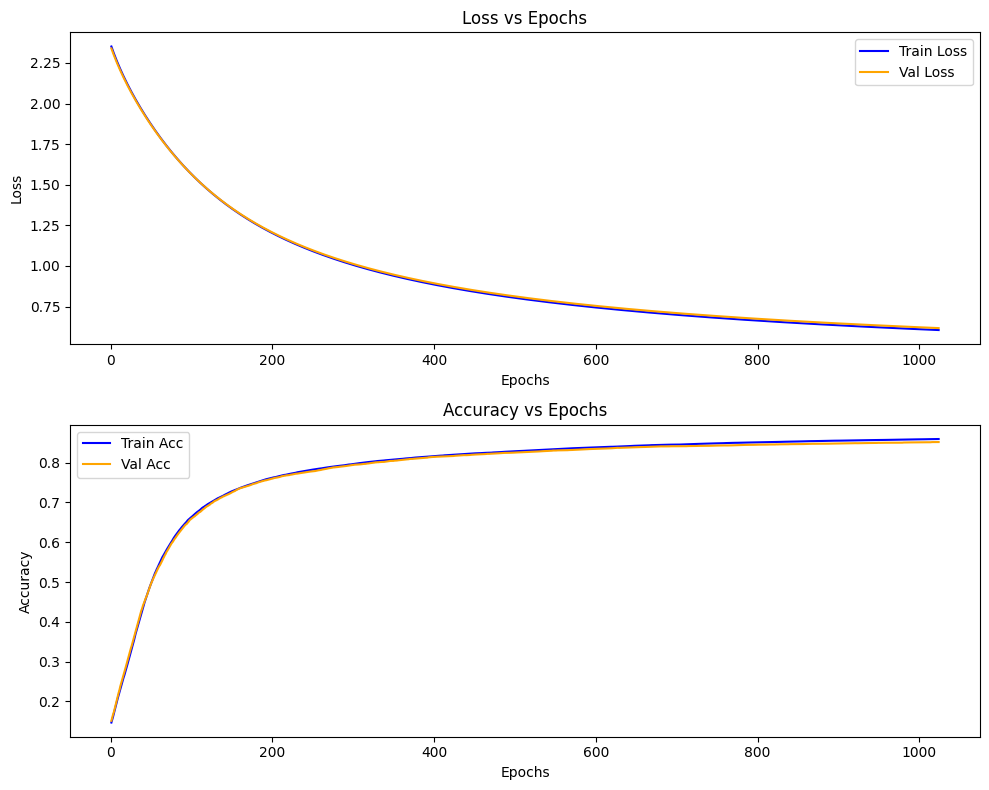

In [111]:
sr = SoftmaxRegression(x_train, y_train, x_val, y_val)
sr.train()

Test accuracy = 0.8557


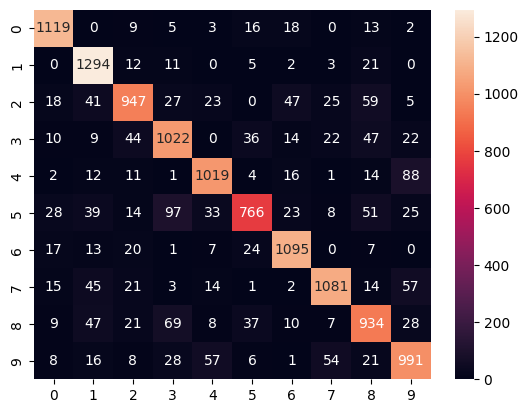

In [113]:
sr.test(x_test, y_test)

## Part B: Neural Network Implementation

### B1: Custom Neural Network Architecture

The neural network class receives a list of integers where each number represents the number of neurons in each layer: [ (Input layer),(Hidden1),(Hidden2),..., (Output) ]

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self,layers_list):
        super().__init__()
        self.net = nn.Sequential()
        for in_, out_ in zip(layers_list, layers_list[1:]):
            lin_layer = nn.Linear(in_, out_); # Current layer and next layer
            self.net.append(lin_layer)
            nn.init.kaiming_normal_(lin_layer.weight, mode='fan_in', nonlinearity='relu')
            self.net.append(nn.ReLU())
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.net(x)
        x = self.softmax(x)
        return x